In [13]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [15]:
X_train.size

47040000

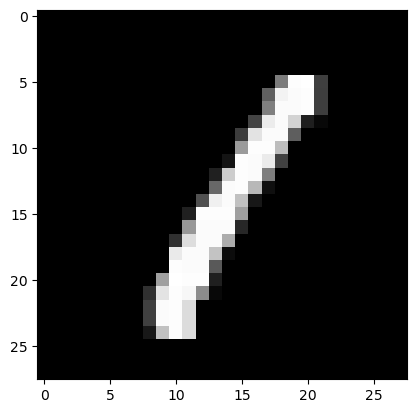

1

In [16]:
from matplotlib import pyplot

pyplot.imshow(X_train[3], cmap=pyplot.get_cmap('gray'))
pyplot.show()
y_train[3]

In [17]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  ' + str(X_test.shape))
print('Y_test:  ' + str(y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [18]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 0, 0, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,690 (3.94 MB)

 Trainable params: 1,031,690 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# save the final model to file
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD


# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    # save model
    model.save('final_model.keras')


# entry point, run the test harness
run_test_harness()

In [20]:
# evaluate the deep model on the test dataset
from keras.models import load_model


# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # load model
    model = load_model('builded_models/final_model.keras')
    # evaluate model on test dataset
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))


# entry point, run the test harness
run_test_harness()

> 99.370


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7


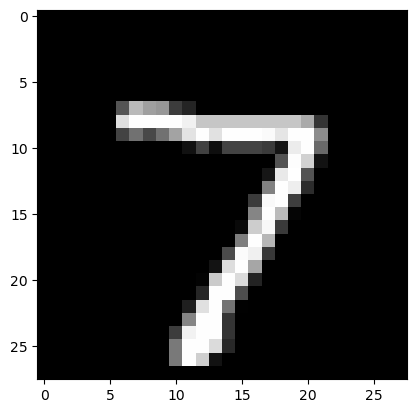

In [31]:
# make a prediction for a new image.
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model


def load_image(filename):
    img = load_img(filename, color_mode="grayscale", target_size=(28, 28))
    img = img_to_array(img)  # convert to array
    img = img.reshape(1, 28, 28, 1)  # reshape into a single sample with 1 channel
    img = img.astype('float32')  # prepare pixel data
    img = img / 255.0
    return img


def run_example():
    img = load_image('test_images/7.png')
    # img = np.random.rand(1, 28, 28, 1) - 0.5
    plt.imshow(img.reshape(28, 28), cmap='gray')
    model = load_model('builded_models/final_model.keras')
    predict_value = model.predict(img)
    digit = argmax(predict_value)
    print(digit)


run_example()

In [ ]:
def best_input_img():    
    target_output = 7  # Define the target output
    num_images = 5
    model = load_model('builded_models/final_model.keras')
    
    for i in range(num_images):
        img = np.random.rand(1, 28, 28, 1) - 0.5  # Generate a random noise image
        plt.imshow(img.reshape(28, 28), cmap='gray')
        closest_output = argmax(model.predict(img))
    
        while target_output != closest_output:
            img += 0.01 * np.random.randn(28, 28, 1)
            closest_output = argmax(model.predict(img))
    
        img = (img + 0.5) * 255
        img = np.uint8(img)
        plt.imshow(img.reshape(28, 28), cmap='gray')

best_input_img()